In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from sklearn.manifold import TSNE

# For reproducibility
np.random.seed(42)


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select digit '8'
x_train_8 = x_train[y_train == 8]
x_test_8 = x_test[y_test == 8]

# Normalize and reshape data
x_train_8 = x_train_8.astype('float32') / 255.
x_test_8 = x_test_8.astype('float32') / 255.
x_train_8 = np.reshape(x_train_8, (len(x_train_8), 28, 28, 1))
x_test_8 = np.reshape(x_test_8, (len(x_test_8), 28, 28, 1))


In [3]:
def build_autoencoder(hidden_layers):
    input_img = Input(shape=(28, 28, 1))
    x = Flatten()(input_img)
    
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)
    
    encoded = Dense(hidden_layers[-1], activation='relu')(x)
    
    x = encoded
    for units in reversed(hidden_layers[:-1]):
        x = Dense(units, activation='relu')(x)
    
    x = Dense(28 * 28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Train autoencoder with different numbers of layers/nodes
autoencoders = {}
hidden_layer_configs = [[2], [10], [20]]

for hidden_layers in hidden_layer_configs:
    autoencoder = build_autoencoder(hidden_layers)
    autoencoder.fit(x_train_8, x_train_8, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_8, x_test_8))
    autoencoders[tuple(hidden_layers)] = autoencoder


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6906 - val_loss: 0.6738
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6576 - val_loss: 0.5823
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5496 - val_loss: 0.4389
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4115 - val_loss: 0.3339
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3221 - val_loss: 0.2869
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2842 - val_loss: 0.2683
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2685 - val_loss: 0.2600
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2604 - val_loss: 0.2555
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2569 - val_loss: 0.2524
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2546 - val_loss: 0.2506
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2513 - val_loss: 0.2492
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2501 - val_lo

Reconstruction with hidden layers: (2,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


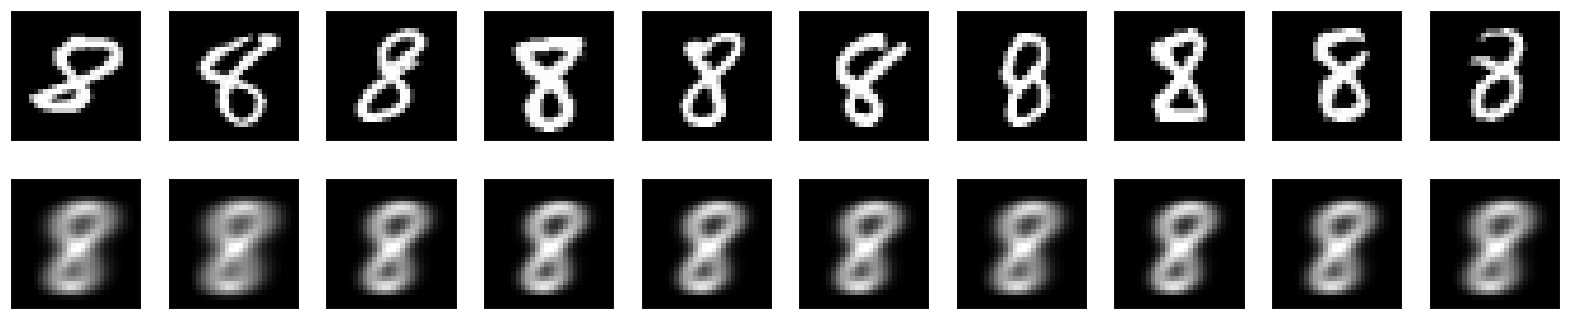

Reconstruction with hidden layers: (10,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


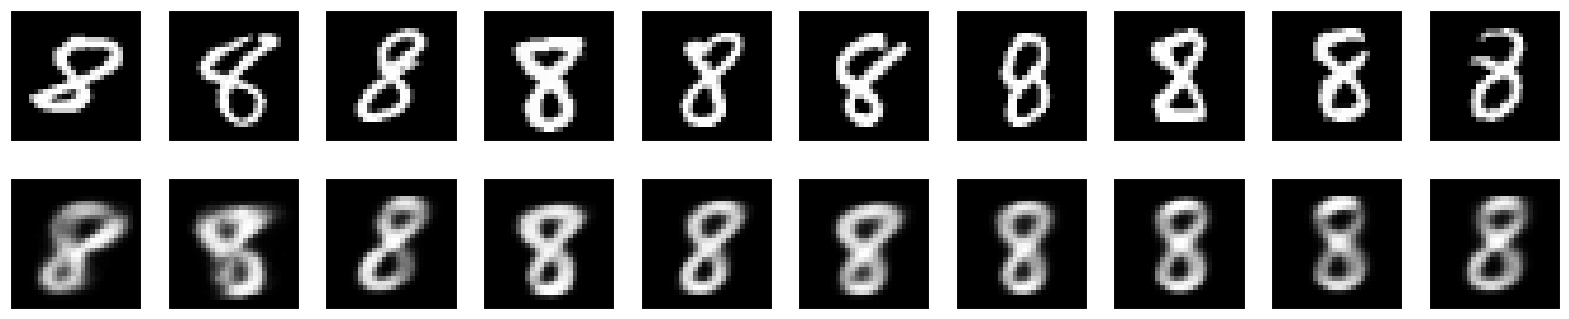

Reconstruction with hidden layers: (20,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


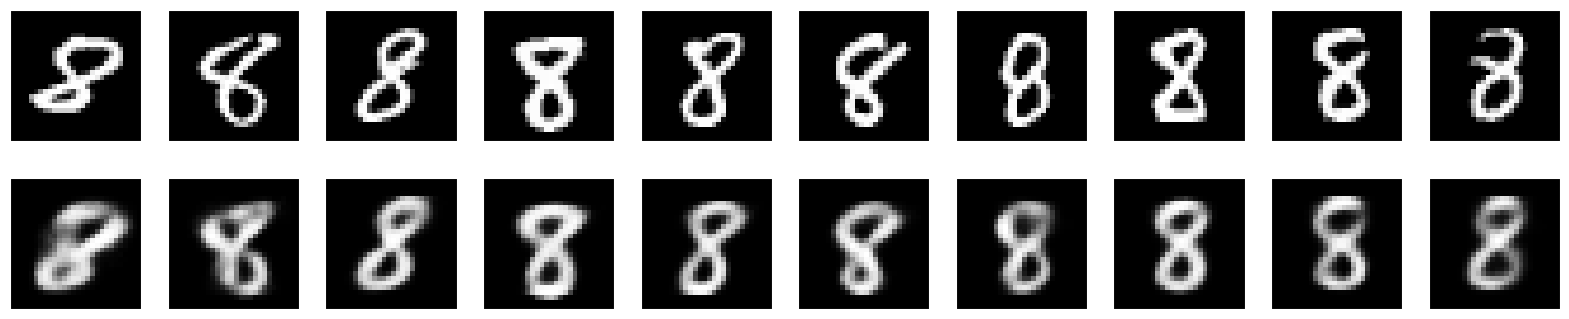

In [4]:
def visualize_reconstruction(autoencoder, x_test, n=10):
    decoded_imgs = autoencoder.predict(x_test)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

for hidden_layers, autoencoder in autoencoders.items():
    print(f"Reconstruction with hidden layers: {hidden_layers}")
    visualize_reconstruction(autoencoder, x_test_8)


Latent space visualization with hidden layers: (2,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


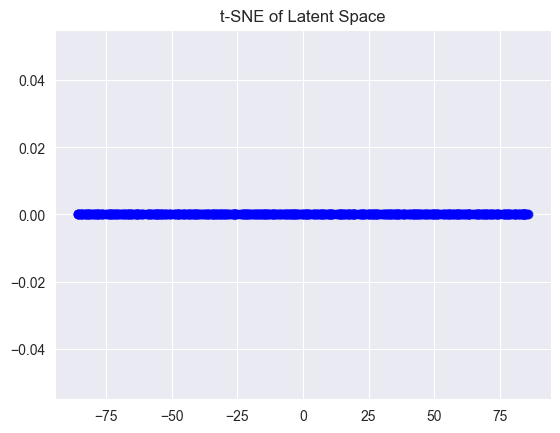

Latent space visualization with hidden layers: (10,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


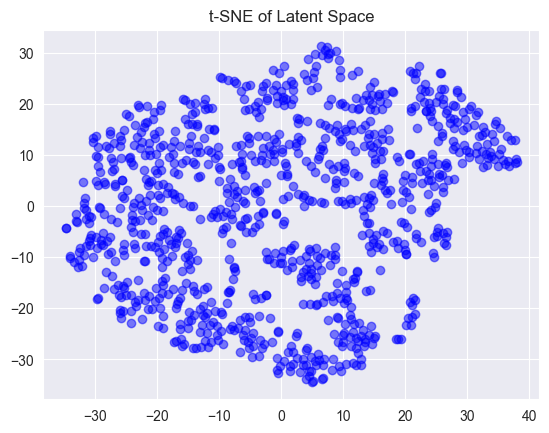

Latent space visualization with hidden layers: (20,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


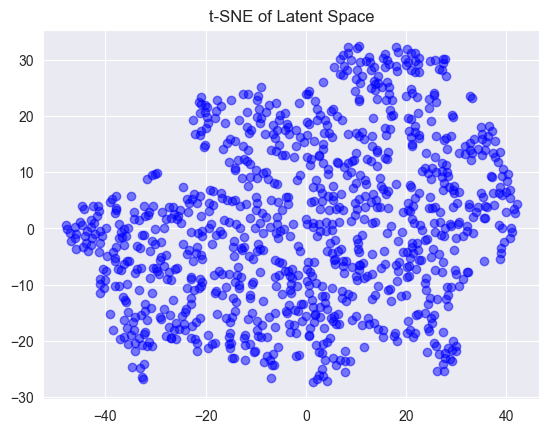

In [5]:
def visualize_latent_space(autoencoder, x_test):
    encoder = Model(autoencoder.input, autoencoder.layers[-4].output)
    encoded_imgs = encoder.predict(x_test)
    encoded_imgs = encoded_imgs.reshape((encoded_imgs.shape[0], -1))
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_imgs)

    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c='blue', alpha=0.5)
    plt.title('t-SNE of Latent Space')
    plt.show()

for hidden_layers, autoencoder in autoencoders.items():
    print(f"Latent space visualization with hidden layers: {hidden_layers}")
    visualize_latent_space(autoencoder, x_test_8)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1752 - val_loss: 0.1919
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1739 - val_loss: 0.1919
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1740 - val_loss: 0.1918
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1742 - val_loss: 0.1918
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1724 - val_loss: 0.1919
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1736 - val_loss: 0.1916
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1729 - val_loss: 0.1916
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1731 - val_loss: 0.1914
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1731 - val_loss: 0.1912
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1724 - val_loss: 0.1915
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1716 - val_loss: 0.1916
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1711 - val_lo

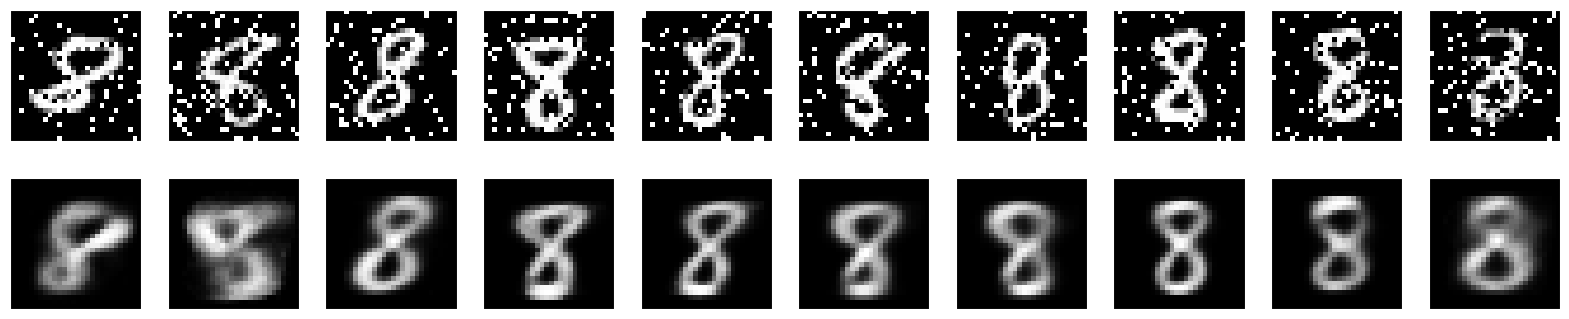

In [7]:
def add_salt_and_pepper_noise(images, amount=0.2):
    noisy_images = images.copy()
    num_salt = np.ceil(amount * images.size * 0.5)
    num_pepper = np.ceil(amount * images.size * 0.5)

    # Add Salt noise
    coords = [np.random.randint(0, i, int(num_salt)) for i in images.shape]
    noisy_images[coords[0], coords[1], coords[2]] = 1

    # Add Pepper noise
    coords = [np.random.randint(0, i, int(num_pepper)) for i in images.shape]
    noisy_images[coords[0], coords[1], coords[2]] = 0

    return noisy_images

# Apply salt and pepper noise
x_test_noisy = add_salt_and_pepper_noise(x_test_8)


autoencoder = autoencoders[(10,)]  # Using one of the trained autoencoders for denoising
autoencoder.fit(x_train_8, x_train_8, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test_8))

print("Reconstruction with noisy data:")
visualize_reconstruction(autoencoder, x_test_noisy)


In [9]:
def visualize_intermediate_layers(autoencoder, x_test, layer_indices=[2, 4, 6]):
    layer_outputs = [autoencoder.layers[i].output for i in layer_indices]
    activation_model = Model(inputs=autoencoder.input, outputs=layer_outputs)
    activations = activation_model.predict(x_test)

    for i, activation in enumerate(activations):
        plt.figure(figsize=(20, 8))
        n = activation.shape[-1]
        for j in range(n):
            ax = plt.subplot(8, n//8, j + 1)
            plt.imshow(activation[0, :, :, j], cmap='viridis')
            plt.axis('off')
        plt.show()

visualize_intermediate_layers(autoencoder, x_test_noisy)


IndexError: list index out of range

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


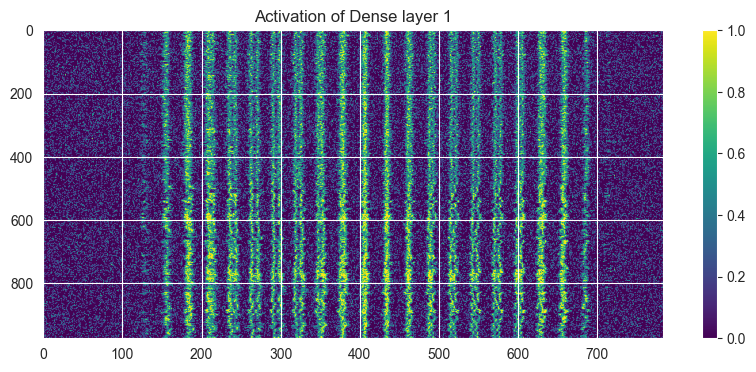

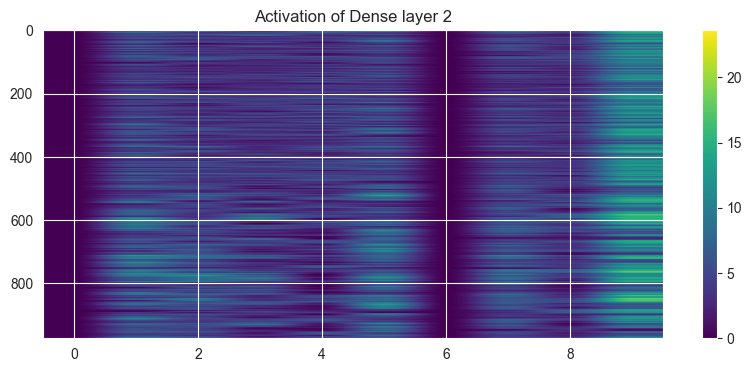

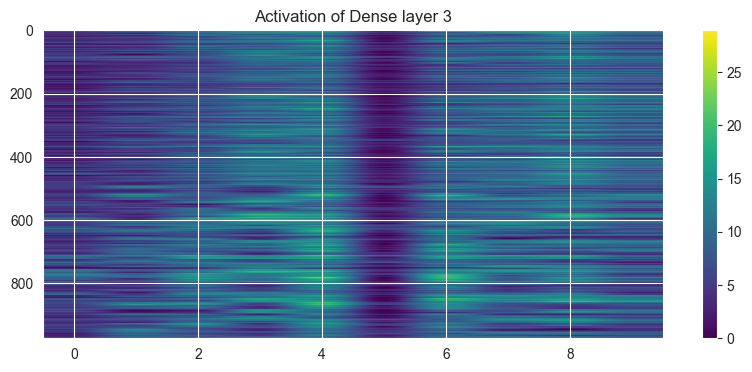

In [11]:
def visualize_intermediate_layers(autoencoder, x_test, num_layers=3):
    layer_outputs = [layer.output for layer in autoencoder.layers[1:num_layers+1]]
    activation_model = Model(inputs=autoencoder.input, outputs=layer_outputs)
    activations = activation_model.predict(x_test)

    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # For Conv2D layers
            num_filters = activation.shape[-1]
            size = activation.shape[1]
            n_cols = num_filters // 8
            plt.figure(figsize=(20, n_cols * 2))
            for j in range(num_filters):
                ax = plt.subplot(n_cols, 8, j + 1)
                plt.imshow(activation[0, :, :, j], cmap='viridis')
                plt.axis('off')
            plt.show()
        elif len(activation.shape) == 2:  # For Dense layers
            plt.figure(figsize=(10, 4))
            plt.imshow(activation, aspect='auto', cmap='viridis')
            plt.colorbar()
            plt.title(f'Activation of Dense layer {i+1}')
            plt.show()

# Use a safe number of layers to visualize (you can adjust this number)
visualize_intermediate_layers(autoencoder, x_test_noisy, num_layers=3)


# Whole dataset

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from sklearn.manifold import TSNE

# For reproducibility
np.random.seed(42)


In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [14]:
# Train autoencoder with different numbers of layers/nodes
autoencoders = {}
hidden_layer_configs = [[2], [10], [20]]

for hidden_layers in hidden_layer_configs:
    autoencoder = build_autoencoder(hidden_layers)
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
    autoencoders[tuple(hidden_layers)] = autoencoder

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5315 - val_loss: 0.2795
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2766 - val_loss: 0.2687
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2682 - val_loss: 0.2651
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2647 - val_loss: 0.2628
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2631 - val_loss: 0.2614
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2610 - val_loss: 0.2601
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2599 - val_loss: 0.2592
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2593 - val_loss: 0.2574
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2570 - val_loss: 0.2560
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2561 - val_loss: 0.2551
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2550 - val_loss: 0.2542
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Reconstruction with hidden layers: (2,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


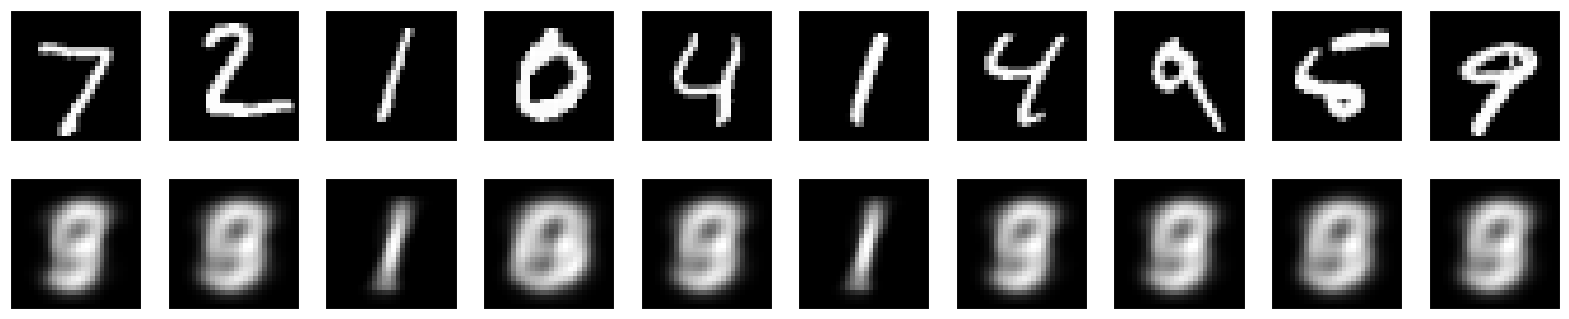

Reconstruction with hidden layers: (10,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


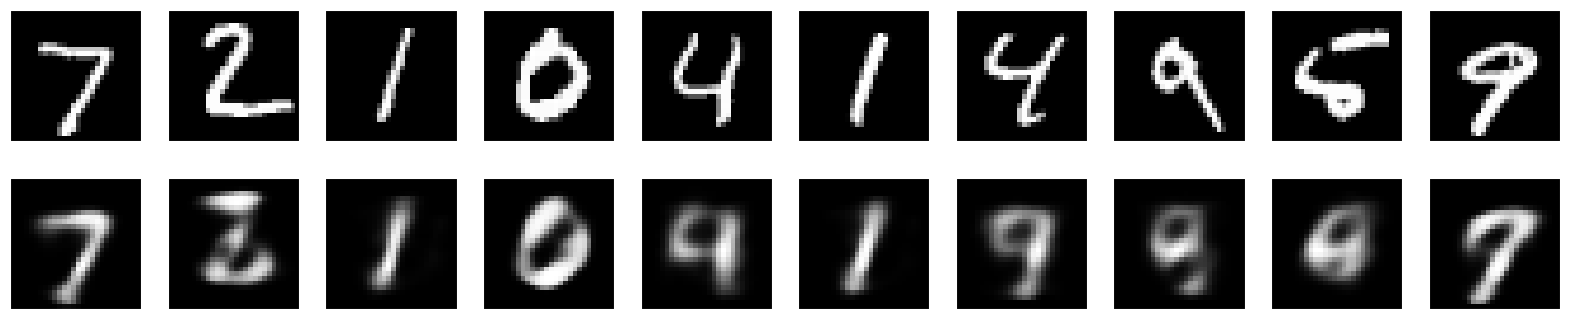

Reconstruction with hidden layers: (20,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


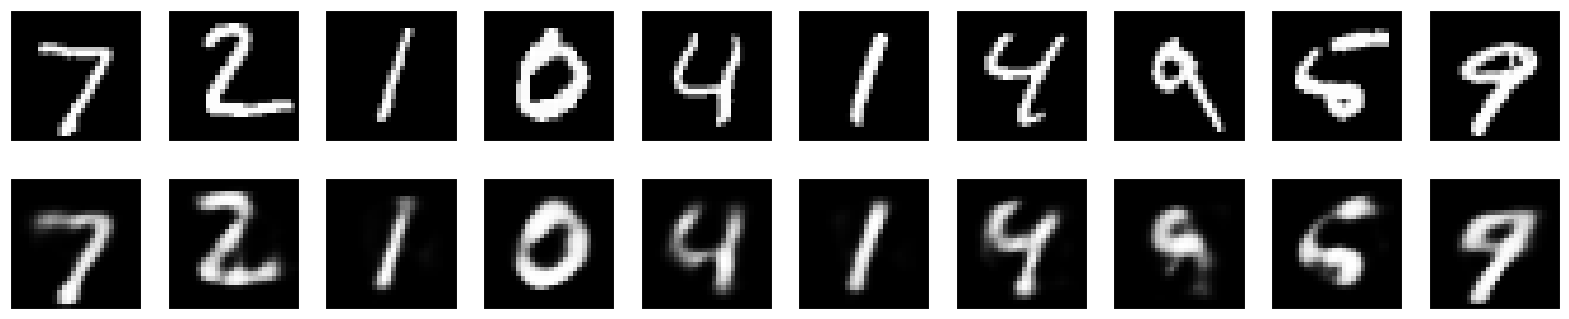

In [15]:
for hidden_layers, autoencoder in autoencoders.items():
    print(f"Reconstruction with hidden layers: {hidden_layers}")
    visualize_reconstruction(autoencoder, x_test)

Latent space visualization with hidden layers: (2,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


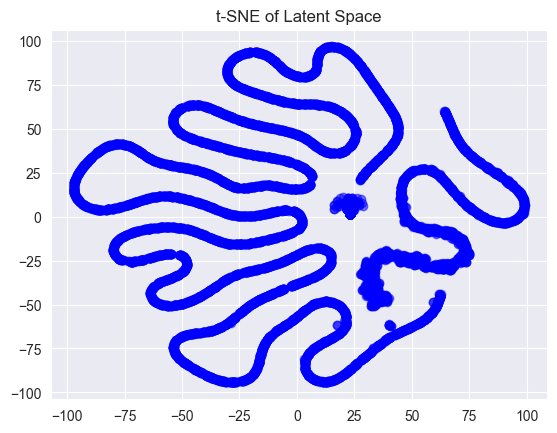

Latent space visualization with hidden layers: (10,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


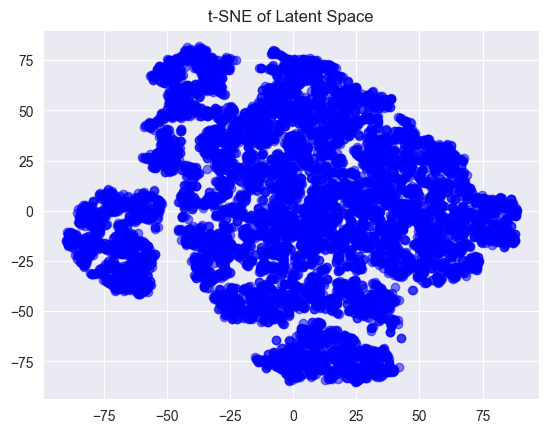

Latent space visualization with hidden layers: (20,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


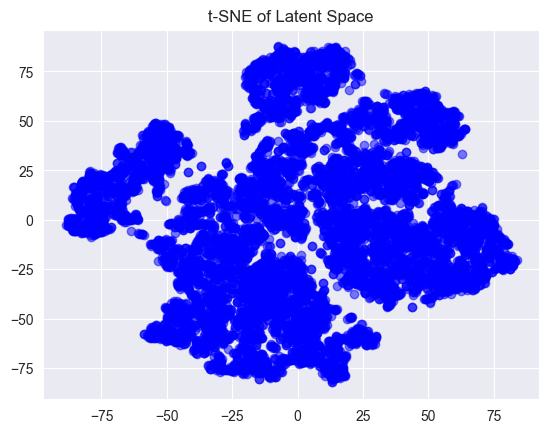

In [16]:
for hidden_layers, autoencoder in autoencoders.items():
    print(f"Latent space visualization with hidden layers: {hidden_layers}")
    visualize_latent_space(autoencoder, x_test)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1642 - val_loss: 0.2358
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1644 - val_loss: 0.2364
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1637 - val_loss: 0.2375
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1640 - val_loss: 0.2399
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1640 - val_loss: 0.2396
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1638 - val_loss: 0.2408
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1637 - val_loss: 0.2399
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1636 - val_loss: 0.2434
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1637 - val_loss: 0.2436
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1636 - val_loss: 0.2441
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1639 - val_loss: 0.2442
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

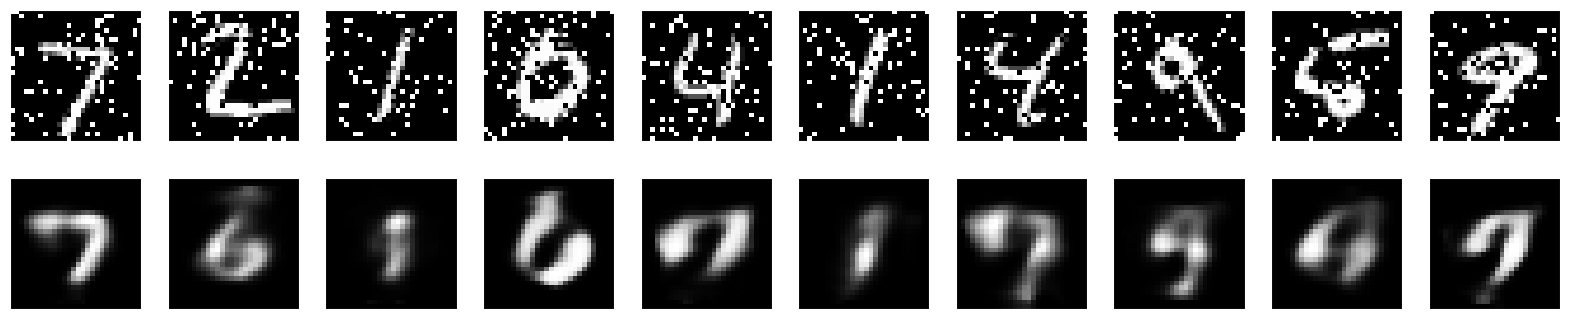

In [17]:
# Apply salt and pepper noise
x_test_noisy = add_salt_and_pepper_noise(x_test)

autoencoder = autoencoders[(10,)]  # Using one of the trained autoencoders for denoising
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test))

print("Reconstruction with noisy data:")
visualize_reconstruction(autoencoder, x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


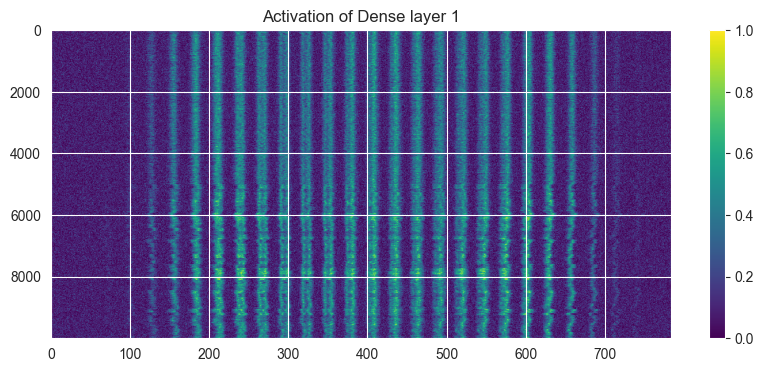

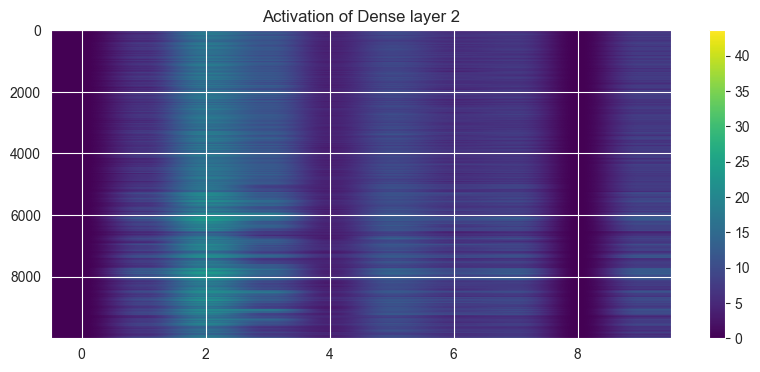

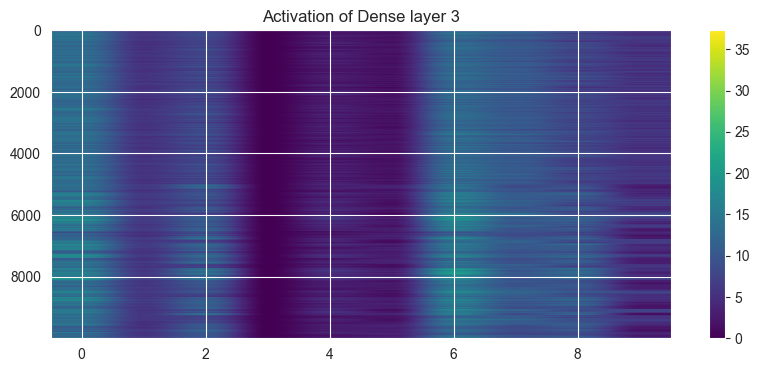

In [18]:
visualize_intermediate_layers(autoencoder, x_test_noisy, num_layers=3)

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │       100,738 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       101,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,258 (790.07 KB)

 Trainable params: 202,258 (790.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3635 - val_loss: 0.2356
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2337 - val_loss: 0.2230
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2216 - val_loss: 0.2127
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2127 - val_loss: 0.2077
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2076 - val_loss: 0.2042
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2043 - val_loss: 0.2019
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2020 - val_loss: 0.2002
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2001 - val_loss: 0.1990
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1983 - val_loss: 0.1977
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1978 - val_loss: 0.1969
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1970 - val_loss: 0.1964
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

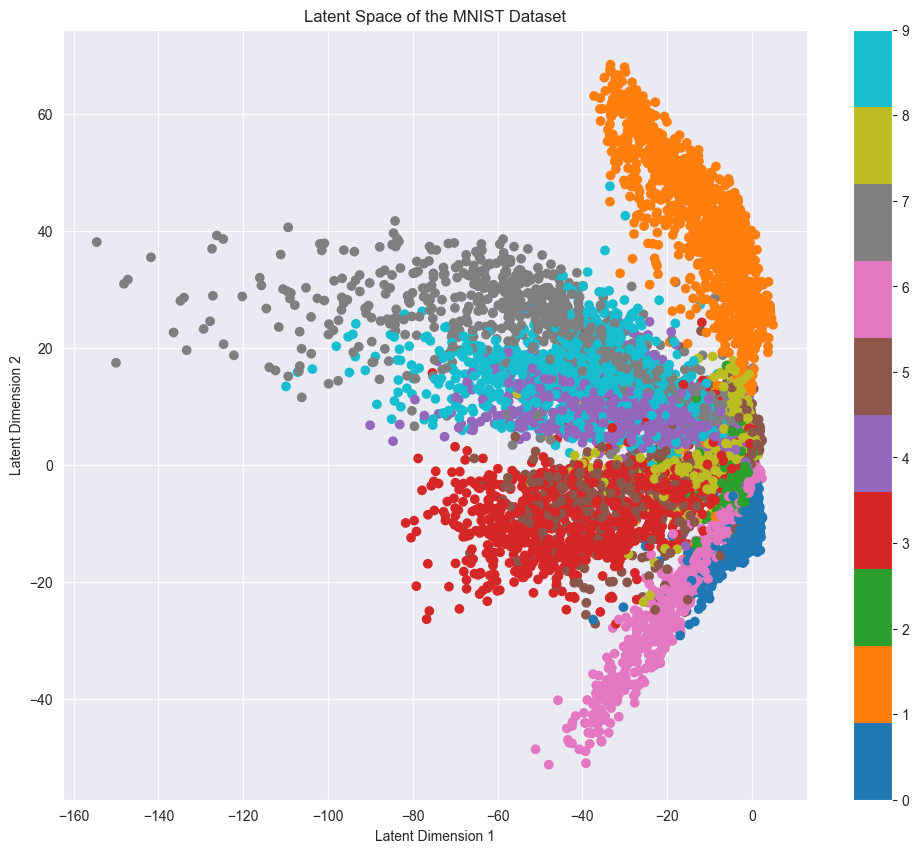

In [21]:

# Normalizing and reshaping the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Network parameters
input_shape = x_train.shape[1]
latent_dim = 2  # Dimensionality of the latent space

# Encoder model
inputs = Input(shape=(input_shape,), name='encoder_input')
x = Dense(128, activation='relu')(inputs)
z = Dense(latent_dim, name='latent_vector')(x)

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(128, activation='relu')(latent_inputs)
outputs = Dense(input_shape, activation='sigmoid')(x)

# Autoencoder model
encoder = Model(inputs, z, name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# Autoencoder configuration
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# Training the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Display the latent space
z_test = encoder.predict(x_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space of the MNIST Dataset")
plt.show()
